In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import seaborn as sns
from sklearn import linear_model
from sklearn import preprocessing;
from sklearn.model_selection import cross_validate as cross_validation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# %matplotlib inline

In [5]:
import datetime
from datetime import timedelta
forecast_out = 365 #Days from now

stock_ticker ='JPM'
stock_parameter ='Low'
epoch_number=50
epoch_number_forecast=50

end = datetime.datetime.now()#-timedelta(7) #remove timedetla -1 to go to productions mode
start = datetime.datetime.now()-timedelta(forecast_out)

# benchmark = web.DataReader(stock_ticker, 'yahoo', start, end )
stock = web.DataReader(stock_ticker, 'yahoo', start, end)


In [7]:
test_size=20
test_index = len(stock[stock_parameter])- test_size

In [9]:
train = stock[stock_parameter].iloc[:test_index]
test= stock[stock_parameter].iloc[test_index:]

In [11]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
scaler=MinMaxScaler()
scaler.fit(train.to_frame())
scaled_train = scaler.transform(train.to_frame())
scaled_test = scaler.transform(test.to_frame())

In [15]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [17]:
length=test_size-1
generator = TimeseriesGenerator(scaled_train,scaled_train, length=length, batch_size=1)

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [21]:
n_features =1
model= Sequential()
# pretty good model at 200 epochs
# model.add(LSTM(50, activation='relu', input_shape=(length, n_features)))
# model.add(Dropout(0.2))
# model.add(Dense(25, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(10, activation='relu'))
# model.add(Dropout(0.2))

model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(15, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='SGD', loss='mse')

In [23]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=1)

In [25]:
validation_generator= TimeseriesGenerator(scaled_test, scaled_test,
                                          length=length, batch_size =1)

In [27]:
# model.fit_generator(generator, epochs=20,
#                    validation_data=validation_generator, callbacks=[early_stop])
model.fit_generator(generator, epochs=epoch_number,
                   validation_data=validation_generator)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 212 steps, validate for 1 steps
Epoch 1/50
212/212 [==============================] - 3s 13ms/step - loss: 0.0111 - val_loss: 1.5858e-04
Epoch 2/50
212/212 [==============================] - 2s 11ms/step - loss: 0.0098 - val_loss: 2.9574e-05
Epoch 3/50
212/212 [==============================] - 2s 11ms/step - loss: 0.0108 - val_loss: 4.6838e-04
Epoch 4/50
212/212 [==============================] - 2s 11ms/step - loss: 0.0104 - val_loss: 1.9039e-04
Epoch 5/50
212/212 [==============================] - 2s 11ms/step - loss: 0.0109 - val_loss: 0.0022
Epoch 6/50
212/212 [==============================] - 2s 11ms/step - loss: 0.0108 - val_loss: 7.4635e-04
Epoch 7/50
212/212 [==============================] - 2s 11ms/step - loss: 0.0130 - val_loss: 0.0015
Epoch 8/50
212/212 [==============================] - 2s 11ms/step - loss: 0.0111 - val_loss: 0.0015
Epoch 9/50
212/212 [==============================] - 2s 11ms/step - loss: 0.009

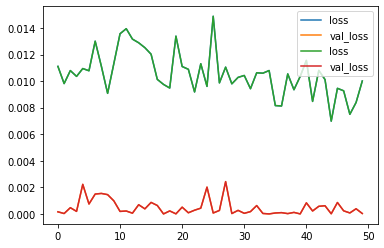

In [29]:
losses= pd.DataFrame(model.history.history)
ax =losses.plot()
losses.plot(ax=ax)
plt.savefig(stock_ticker+'_'+stock_parameter+'loss_chart.png')

In [31]:
test_predictions =[]
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))
for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)

In [33]:
true_predictions =scaler.inverse_transform(test_predictions)


In [35]:
predictions = pd.DataFrame(test)
predictions['Predictions'] = true_predictions

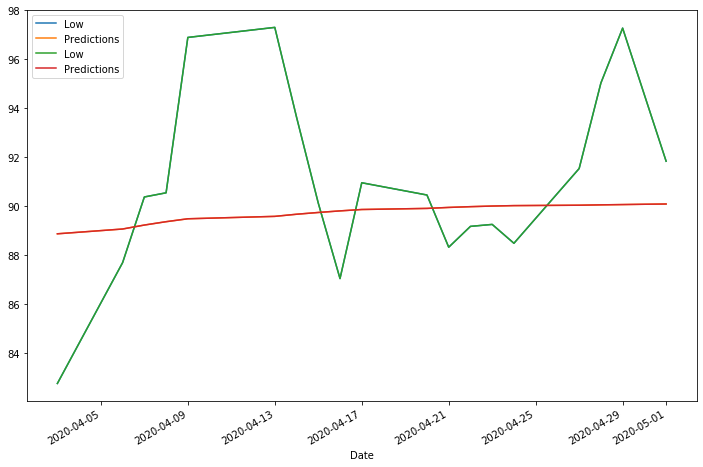

In [37]:
ax=predictions.plot(figsize=(12,8))
predictions.plot(ax=ax)
plt.savefig(stock_ticker+'_'+stock_parameter+'_predictions_chart.png')

In [39]:
from keras.models import load_model
model.save(stock_ticker+'_'+stock_parameter+'prediction'+'.h5')

# Forecasting

In [41]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(stock[stock_parameter].to_frame())

In [43]:
length=19
generator=TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [45]:
forecast_model= Sequential()
forecast_model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
forecast_model.add(Dropout(0.2))
forecast_model.add(Dense(50, activation='relu'))
forecast_model.add(Dropout(0.2))
forecast_model.add(Dense(15, activation='relu'))
forecast_model.add(Dropout(0.2))
forecast_model.add(Dense(1, activation='relu'))
forecast_model.compile(optimizer='SGD', loss='mse')
forecast_model.fit_generator(generator, epochs=epoch_number_forecast)

  ...
    to  
  ['...']
Train for 232 steps
Epoch 1/50
232/232 [==============================] - 4s 17ms/step - loss: 0.0789
Epoch 2/50
232/232 [==============================] - 2s 8ms/step - loss: 0.0451
Epoch 3/50
232/232 [==============================] - 2s 8ms/step - loss: 0.0319
Epoch 4/50
232/232 [==============================] - 2s 8ms/step - loss: 0.0238
Epoch 5/50
232/232 [==============================] - 2s 8ms/step - loss: 0.0243
Epoch 6/50
232/232 [==============================] - 2s 8ms/step - loss: 0.0234
Epoch 7/50
232/232 [==============================] - 2s 8ms/step - loss: 0.0187
Epoch 8/50
232/232 [==============================] - 2s 8ms/step - loss: 0.0203
Epoch 9/50
232/232 [==============================] - 2s 8ms/step - loss: 0.0180
Epoch 10/50
232/232 [==============================] - 2s 8ms/step - loss: 0.0188
Epoch 11/50
232/232 [==============================] - 2s 8ms/step - loss: 0.0173
Epoch 12/50
232/232 [==============================] - 2s 8ms

In [47]:
from keras.models import load_model
model.save(stock_ticker+'_'+stock_parameter+'forecast'+'.h5')

In [49]:
forecast =[]

periods=19

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [51]:
forecast = scaler.inverse_transform(forecast)

In [53]:
forecast

array([[91.28833146],
       [91.0897149 ],
       [90.92325034],
       [90.78491854],
       [90.66959465],
       [90.57453973],
       [90.49665806],
       [90.43303045],
       [90.38101829],
       [90.33624371],
       [90.29957821],
       [90.27034541],
       [90.24582123],
       [90.22557084],
       [90.20909255],
       [90.19442598],
       [90.18145778],
       [90.17036633],
       [90.16193394]])

In [55]:
from datetime import date
forecast_index = pd.date_range(start=date.today(), periods = periods, freq="D")

In [57]:
forecast_df = pd.DataFrame(data = forecast, index=forecast_index, columns=['Forecast'])

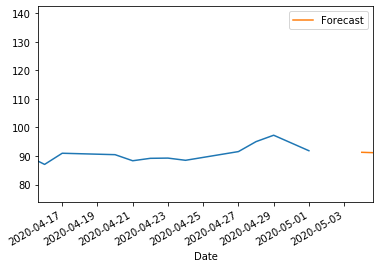

In [59]:
ax=stock[stock_parameter].plot()
forecast_df.plot(ax=ax)
plt.xlim( datetime.datetime.now()-timedelta(periods), datetime.datetime.now())
plt.savefig(stock_ticker+'_'+stock_parameter+'forecast_chart.png')


In [60]:
# todo 
# add save charts 
# add save forecast.csv
forecast_df.to_csv('forecast_'+stock_ticker+'_'+stock_parameter+'.csv')